In [1]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as T

import matplotlib.image as mpimg

from models import Pix2Pix

# Data

- data URL   
https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz

In [2]:
class CityDataset(Dataset):
    def __init__(self, file_dir, size):
        self.file_dir = file_dir
        self.file_list = os.listdir(file_dir)
        self.size = size
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def resize2d(self, img):
        with torch.no_grad():
            img = (F.adaptive_avg_pool2d(Variable(img), (self.size, self.size))).data
        return img

    def __getitem__(self, index):
        x = mpimg.imread(self.file_dir + self.file_list[index])
        y = x[:,256:,:]
        x = x[:,:256,:]
        x = self.transform(x)
        y = self.transform(y)
        if self.size != 256:
            x = self.resize2d(x)
            y = self.resize2d(y)
        return x, y
 
    def __len__(self):
        return len(self.file_list)

In [3]:
dataset = CityDataset('data/cityscapes/train/', 128)
data_loader = DataLoader(dataset, batch_size=64)

In [4]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

dtype = torch.cuda.FloatTensor
l1_lambda = 100
input_size = 128
d = 64

D = Pix2Pix.Discriminator(d, dtype)
G = Pix2Pix.Genereator(input_size, d, dtype)

G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

torch.cuda.random.manual_seed(12345)
G.apply(reset)
D.apply(reset)

Discriminator(
  (features): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [5]:
trainer = Pix2Pix.Trainer(D, D_optimizer, G, G_optimizer, l1_lambda, dtype)

Starting 1/50
Starting 2/50
Starting 3/50
Starting 4/50
Starting 5/50
Time: 33.4760, D loss 0.0002, G loss 40.0877


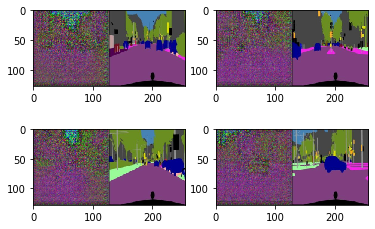

Starting 6/50
Starting 7/50
Starting 8/50
Starting 9/50
Starting 10/50
Time: 33.3962, D loss 0.0001, G loss 39.3618


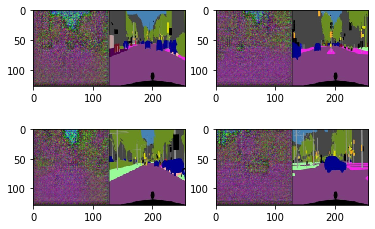

Starting 11/50
Starting 12/50
Starting 13/50
Starting 14/50
Starting 15/50
Time: 33.9420, D loss 0.0001, G loss 38.9284


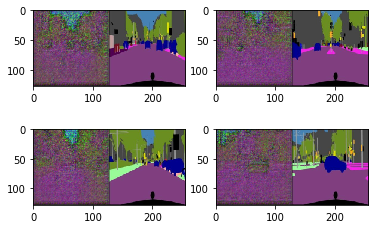

Starting 16/50
Starting 17/50
Starting 18/50
Starting 19/50
Starting 20/50
Time: 33.0807, D loss 0.0000, G loss 38.6896


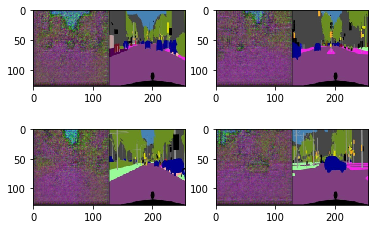

Starting 21/50
Starting 22/50
Starting 23/50
Starting 24/50
Starting 25/50
Time: 33.1509, D loss 0.0000, G loss 38.5543


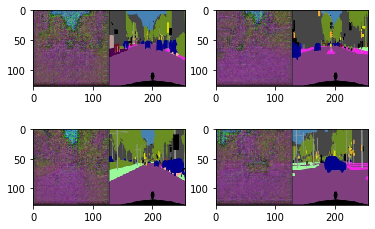

Starting 26/50
Starting 27/50
Starting 28/50
Starting 29/50
Starting 30/50
Time: 33.0562, D loss 0.0000, G loss 38.4813


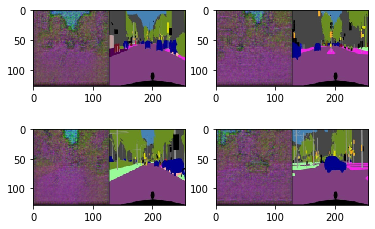

Starting 31/50
Starting 32/50
Starting 33/50
Starting 34/50
Starting 35/50
Time: 33.1746, D loss 0.0000, G loss 38.4180


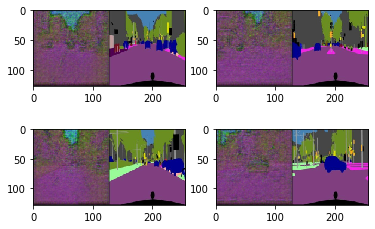

Starting 36/50
Starting 37/50
Starting 38/50
Starting 39/50
Starting 40/50
Time: 33.1491, D loss 0.0000, G loss 38.4005


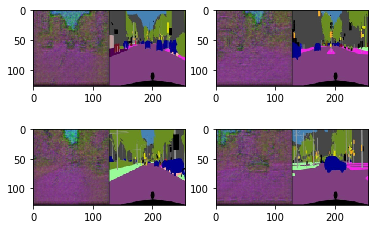

Starting 41/50
Starting 42/50
Starting 43/50
Starting 44/50
Starting 45/50
Time: 33.1724, D loss 0.0000, G loss 38.4316


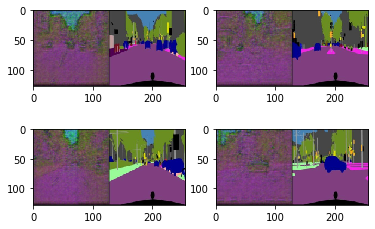

Starting 46/50
Starting 47/50
Starting 48/50
Starting 49/50
Starting 50/50
Time: 33.5257, D loss 0.0000, G loss 38.4940


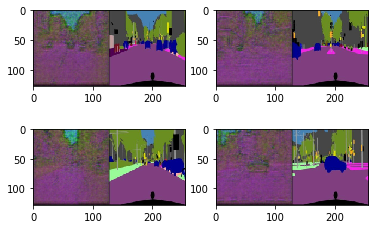

In [7]:
trainer.train(50, data_loader, 5, 4)

In [ ]:
torch.save(trainer.D.state_dict(), 'checkpoint/city/190526/discriminator_param.pkl')
torch.save(trainer.G.state_dict(), 'checkpoint/city/190526/generator_param.pkl')